Alumna: Maria Alejandra Del Porto

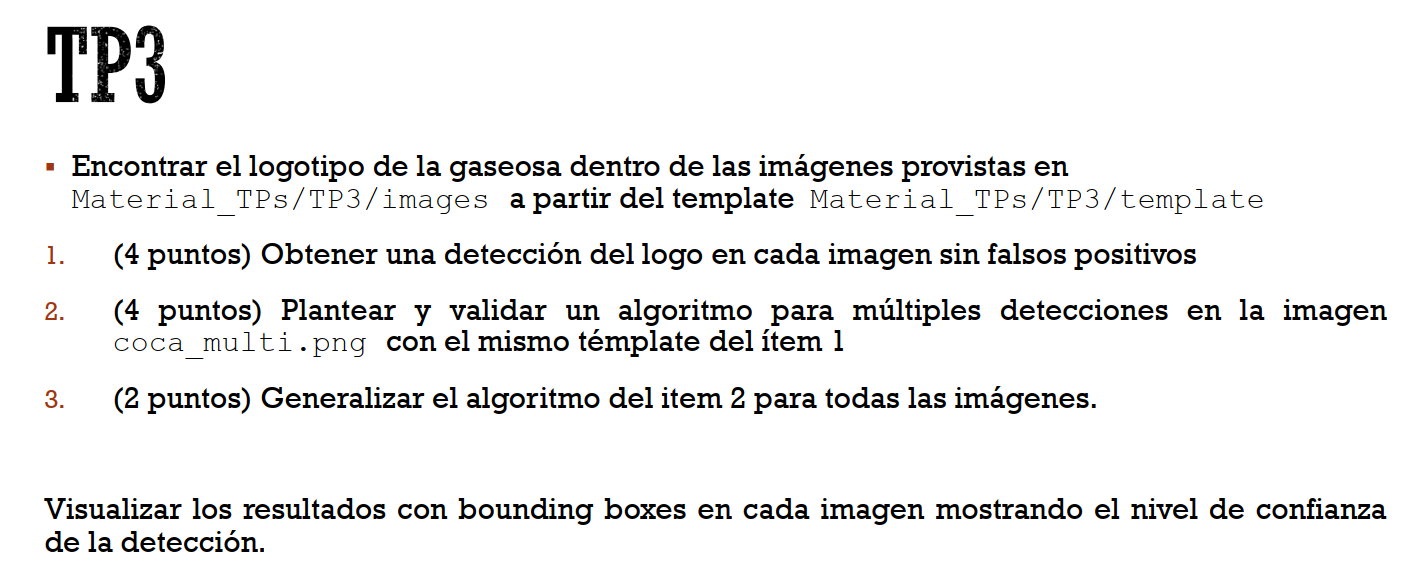

In [27]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib

import numpy as np
import cv2 as cv
import cv2
import math
import matplotlib.pyplot as plt
import os

## ---------------------------------- PARTE 1 ----------------------------------

### Imagenes a procesar y template

Nombre: COCA-COLA-LOGO.jpg


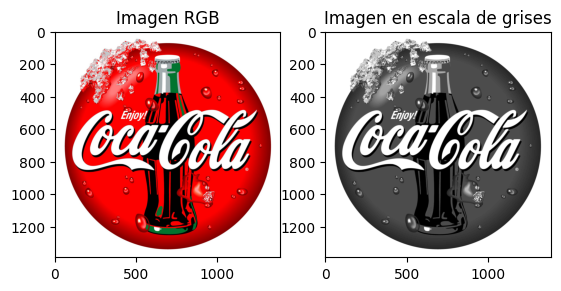

Nombre: coca_logo_1.png


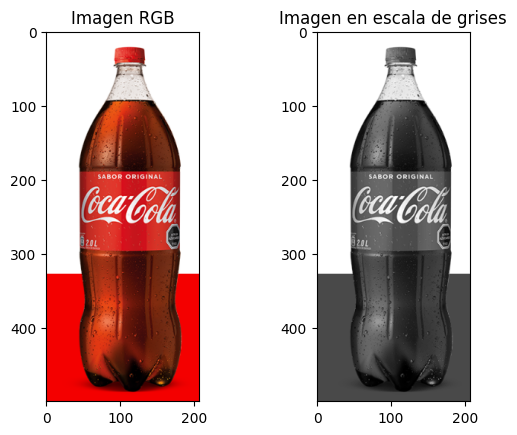

Nombre: coca_logo_2.png


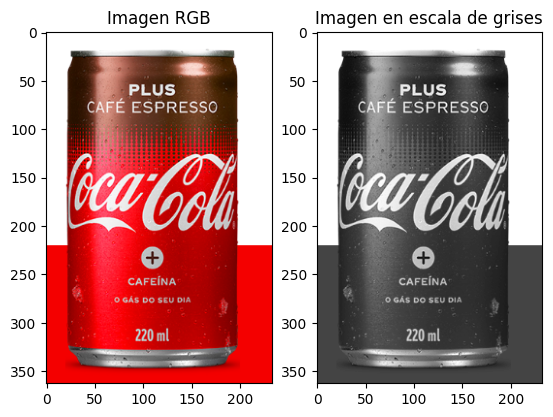

Nombre: coca_multi.png


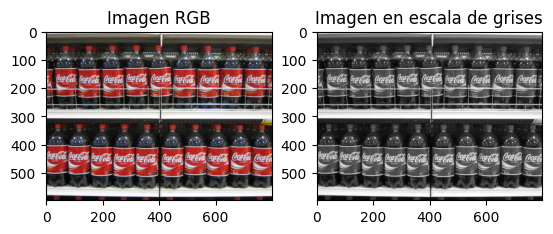

Nombre: coca_retro_1.png


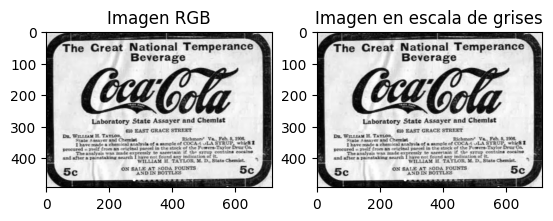

Nombre: coca_retro_2.png


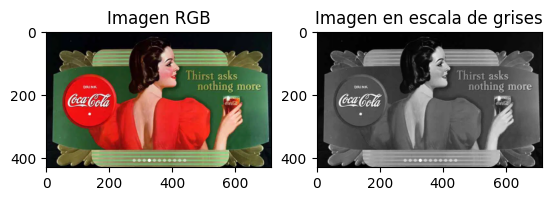

Nombre: logo_1.png


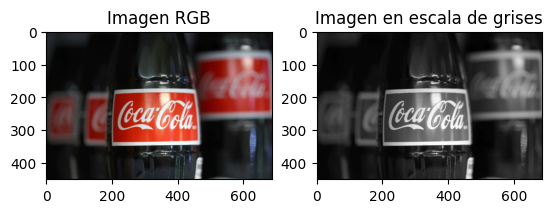

In [28]:
# Carga de las imagenes a procesar

# Ruta de la carpeta de imágenes
folder_path = './images/'  # Ajusta la ruta según la ubicación de tu carpeta

# Lista para almacenar la información de las imágenes
images_info = []

# Recorre los archivos en la carpeta de imágenes
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtra solo archivos de imagen
        # Lee la imagen
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is not None:
            # Convierte la imagen a RGB y escala de grises
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Guarda la información en un diccionario
            image_data = {
                'nombre': filename,
                'imagen_rgb': img_rgb,
                'imagen_gris': img_gray
            }

            # Agrega el diccionario a la lista
            images_info.append(image_data)

# Acceder a la información de las imágenes cargadas
for image_data in images_info:
    print(f"Nombre: {image_data['nombre']}")
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_data['imagen_rgb'])
    plt.title('Imagen RGB')
    plt.subplot(1, 2, 2)
    plt.imshow(image_data['imagen_gris'], cmap='gray')
    plt.title('Imagen en escala de grises')
    plt.show()


Text(0.5, 1.0, 'Template')

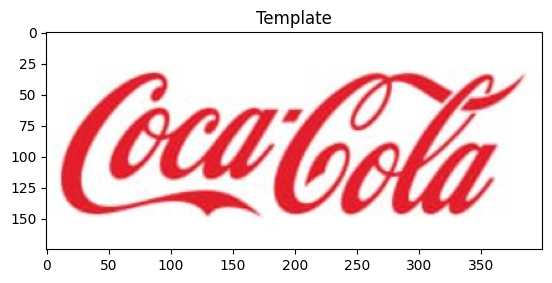

In [29]:
# Carga del template
template = cv.imread('.\\template\\pattern.png')
template_rgb = cv.cvtColor(template, cv.COLOR_BGR2RGB)
template_gray = cv.cvtColor(template, cv2.COLOR_BGR2GRAY)

# Visualizar imagenes y template
plt.figure()
plt.imshow(template_rgb, cmap='gray')
plt.title("Template")


Text(0.5, 1.0, 'template_gray')

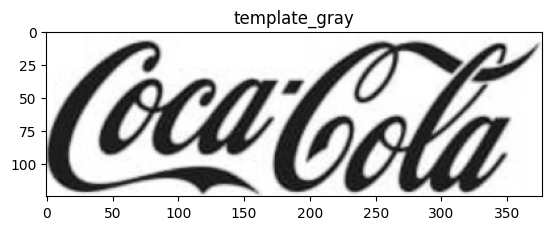

In [30]:
# Recorto el template para dejar eliminar los pixeles que no aportan al logo

template_gray = template_gray[25:150, 11:388]

plt.figure()
plt.imshow(template_gray, cmap='gray')
plt.title("template_gray")

### Método de detección del logo

La solución implementada logró detectar correctamente los logos luego de realizar el siguiente pre procesamiento del template y/o la imagen:

* *Redimensionamiento del template*: se busca que el tamaño del template sea lo más cercano posible al tamaño del logo en la imagen a procesar.
   Se va probando con una lista de escalas y me quedo con el valor de escalado que arroja el mejor valor de la métrica. Como métrica utilicé los valores min_val y max_val (según corresponda) que devuelve la funcion cv.minMaxLoc(res) luego de realizado el template matching. 
* *Detección de bordes con Canny*: fue necesario realizar este pre-procesamiento para mejorar la detección.


Oportunidades de mejora:

* La funcion solo está pensada para métodos normalizados dada la manera en que se iniciliza la variable auxiliar best_val, queda pendiente generalizar a cualquier método.

* Probar automáticamente distintos métodos de template matching para cada imagen.

* Encontrar manera de no terner que pasar como argumento de la funcion la lista de escalas a probar (list_scale) y los umbrales para el detector de Canny (canny_threshold1 y canny_threshold2), dado que tuve que ir probando valores factibles para cada imagen a procesar.

* Probar una métrica de coincidencia que sea más efectiva que min_val o max_val, dado que cuando empezaba a probar con valores chicos de escala determinaba la mejor detección para esos valores chicos pero que no coincidia con el logo sino con una parte de este u otra palabra directamente. Me quedó pendiente probar IoU, NMS, etc.

* Probar con otros algoritmos como, por ejemplo, detección de características.


In [31]:
# Definición del la función de detección de logo
def detectar_logo(img_gray, img_rgb, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template):
    
    # Carga del método para la detección
    method = eval(metodo)

    # Iteramos sobre diferentes tamaños de la plantilla (mayores y menores) y obtenemos la mejor deteccion

    ## inicializacion de varibles
    if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
        best_val = 1
    else:
        best_val = 0
    # Iteracion
    for scale in scale_list:

        # Redimensiono del template
        template_scaled = cv.resize(template_gray, None, fx=scale, fy=scale)
        
        # Si el tamaño de la plantilla es mayor que la imagen, dejamos de iterar
        if template_scaled.shape[0] > img_gray.shape[0] or template_scaled.shape[1] > img_gray.shape[1]:
            print("el tamaño de la plantilla es mayor que la imagen")
            break
        
        # Copia de la imagen color 
        img_salida = img_rgb.copy()

        # Aplico el Detector de Canny a fin de mejorar la deteccion del logo en la imagen
        img_canny = cv.Canny(img_salida, threshold1=canny_threshold1_img, threshold2=canny_threshold2_img)
        template_canny = cv.Canny(template_scaled, threshold1=canny_threshold1_template, threshold2=canny_threshold2_template)

        # Aplico el template matching con el template redimensionada
        res = cv.matchTemplate(img_canny, template_canny, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Busqueda del valore de scale que brinda la mejor detección
        if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
            if abs(min_val) < best_val:
                best_val = abs(min_val)
                top_left = min_loc
                best_res = res
                best_template_canny = template_canny
        else:
            if max_val > best_val:
                best_val = max_val
                top_left = max_loc
                best_res = res
                best_template_canny = template_canny
                best_scale = scale

    # Mostrar la detección del logo en la imagen color
    w, h = best_template_canny.shape[::-1]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida, top_left, bottom_right, (0, 0, 255), 3)

    return best_template_canny, img_canny, best_res, img_salida, best_val, best_scale


In [32]:
# Definición del la función de graficación de resultados
def graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val):
    # Gráficos de los resultados
    plt.figure()
    plt.subplot(311), plt.imshow(best_template_canny)
    plt.title('template_canny'), plt.xticks([]), plt.yticks([])
    plt.subplot(312), plt.imshow(img_canny, cmap='gray')
    plt.title('img_canny'), plt.xticks([]), plt.yticks([])
    plt.subplot(313), plt.imshow(best_res)
    plt.title('Matching'), plt.xticks([]), plt.yticks([])
    plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
    plt.show()

    plt.figure()
    plt.imshow(img_salida)
    plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
    plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
    plt.show()

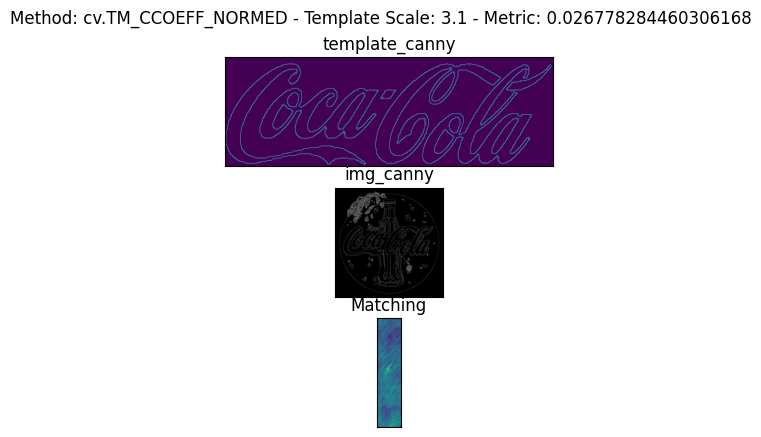

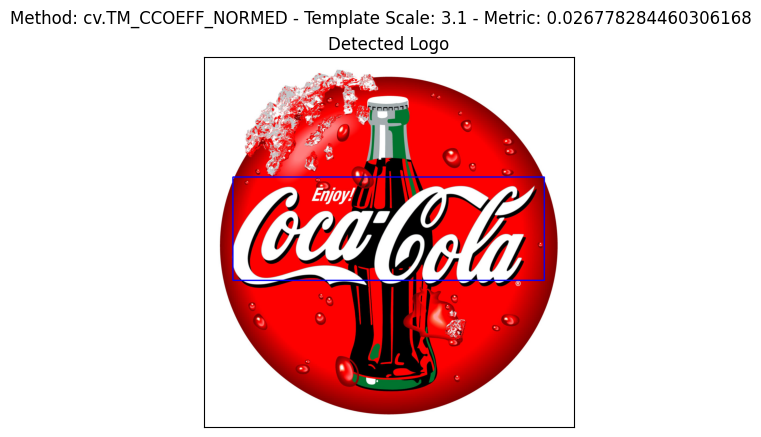

In [33]:
# Detección de logo en imagen seleccionada
imagen = 0
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 2.8, 2.9, 3, 3.1, 3.3]
canny_threshold1_img = 200
canny_threshold2_img = 200
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)

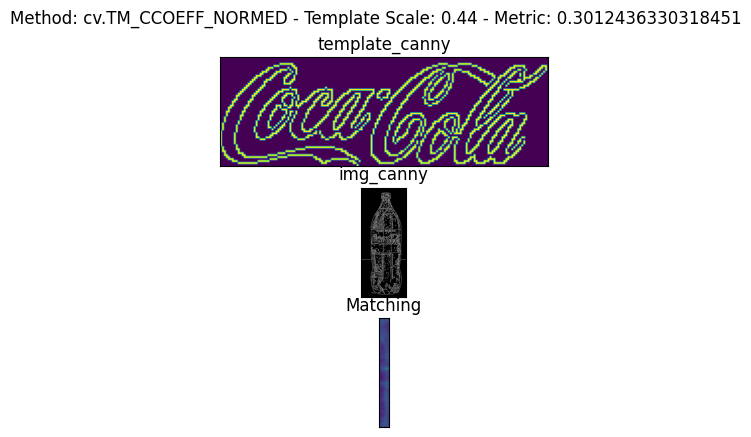

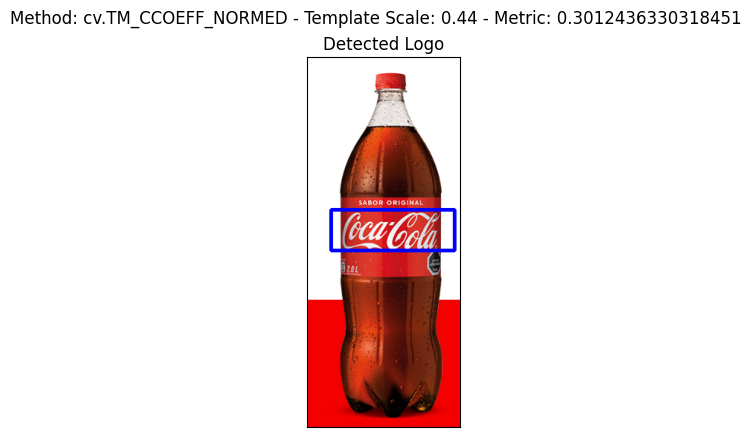

In [34]:
# Detección de logo en imagen seleccionada
imagen = 1
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [0.38, 0.40, 0.42, 0.44, 0.46, 0.48, 0.50]
canny_threshold1_img = 50
canny_threshold2_img = 100
canny_threshold1_template = 50
canny_threshold2_template = 100

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)

el tamaño de la plantilla es mayor que la imagen


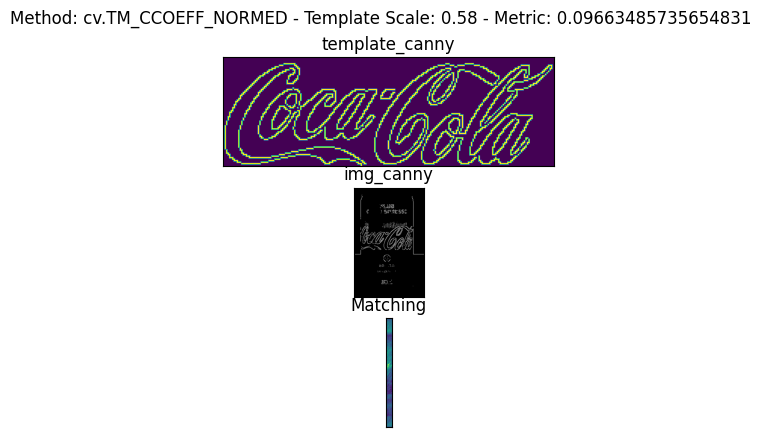

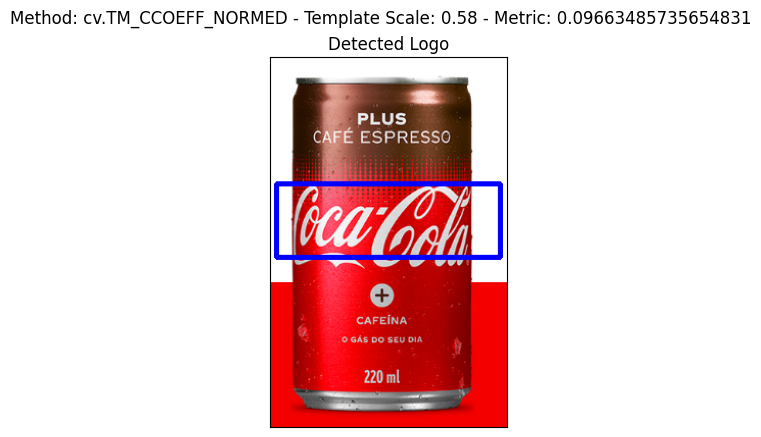

In [35]:
# Detección de logo en imagen seleccionada
imagen = 2
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [0.4, 0.58, 0.585, 0.59, 0.6, 0.65,  0.7]
canny_threshold1_img = 900
canny_threshold2_img = 925
canny_threshold1_template = 50
canny_threshold2_template = 100

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)

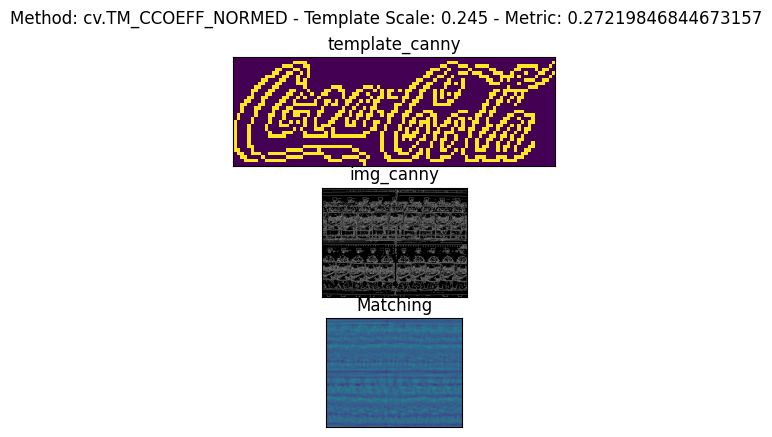

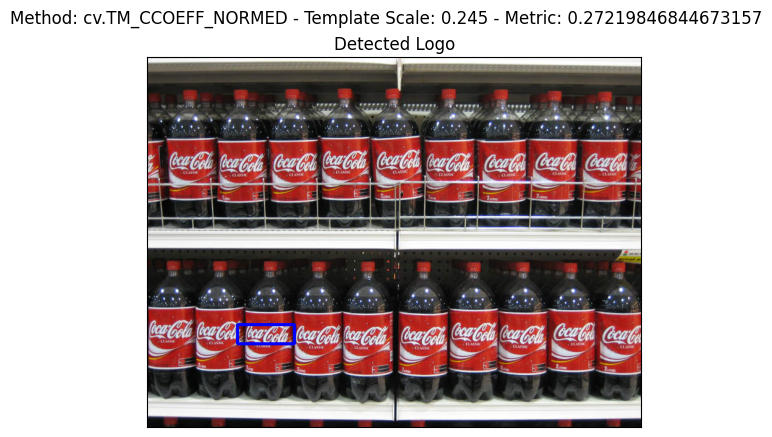

In [36]:
# Detección de logo en imagen seleccionada
imagen = 3
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.22, 0.235, 0.24, 0.245, 0.29]
canny_threshold1_img = 100
canny_threshold2_img = 100
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)


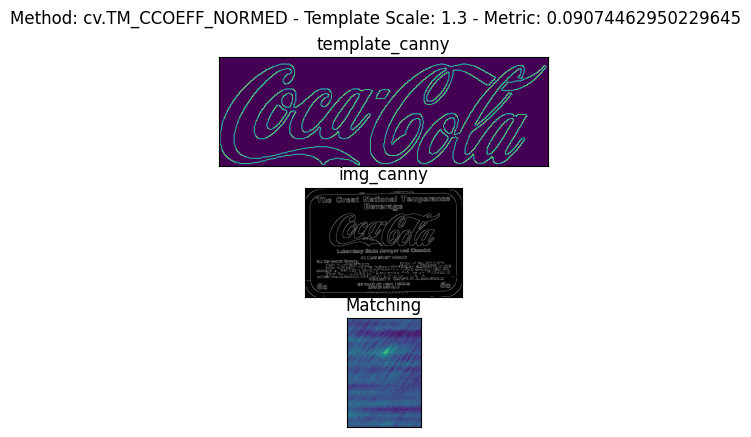

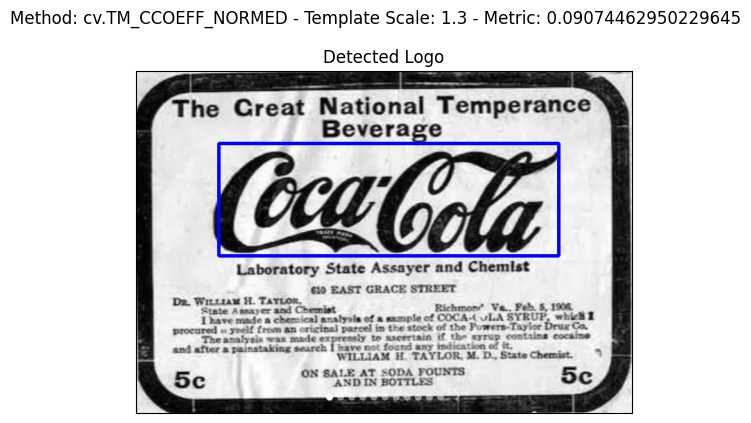

In [37]:
# Detección de logo en imagen seleccionada
imagen = 4
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.9, 1, 1.2, 1.3, 1.4]
canny_threshold1_img = 400
canny_threshold2_img = 400
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)

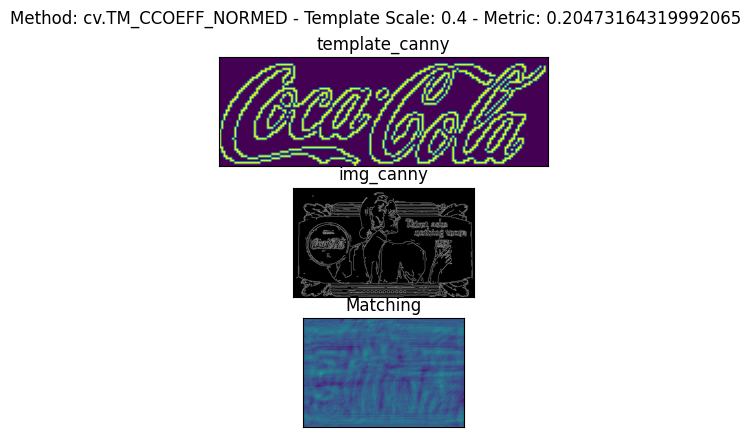

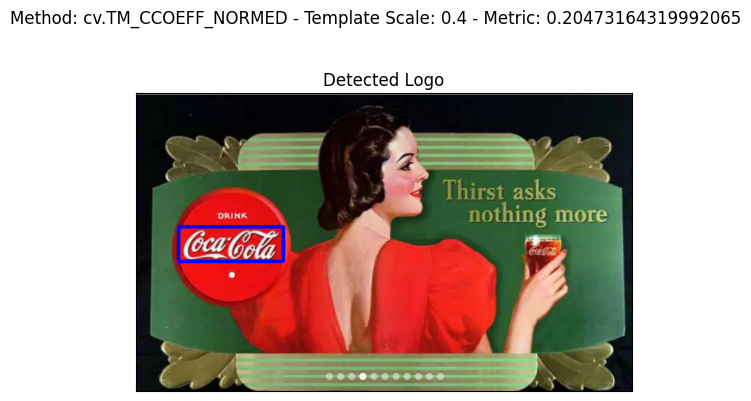

In [38]:
# Detección de logo en imagen seleccionada
imagen = 5
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.3, 0.4, 0.5, 0.6]
canny_threshold1_img = 100
canny_threshold2_img = 50
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)

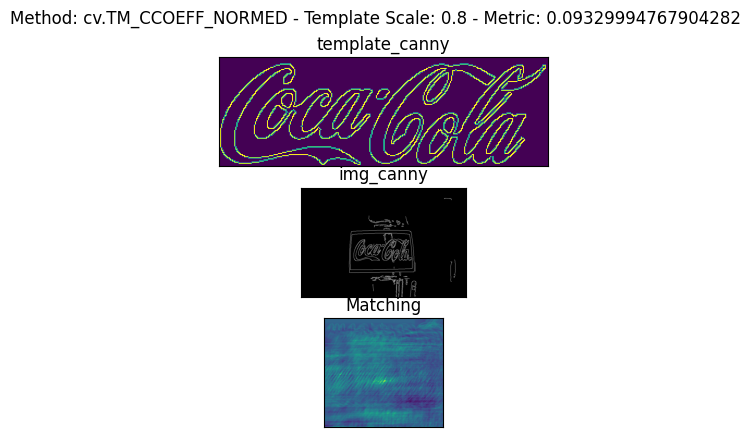

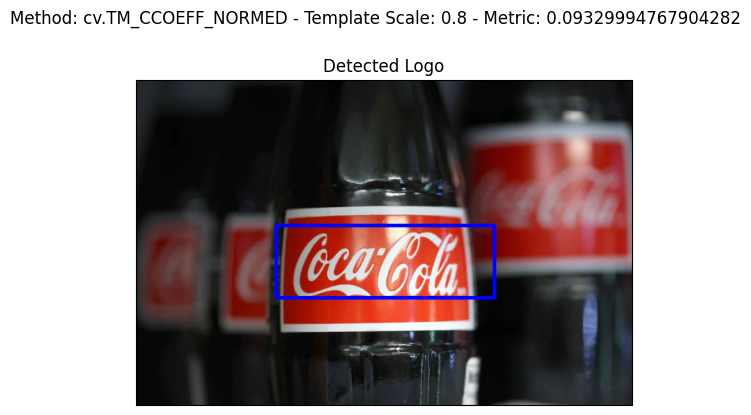

In [39]:
# Detección de logo en imagen seleccionada
imagen = 6
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.4, 0.6, 0.8, 0.9, 1, 1.25]
canny_threshold1_img = 200
canny_threshold2_img = 100
canny_threshold1_template = 200
canny_threshold2_template = 100

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)

## ---------------------------------- PARTE 2 ----------------------------------

In [40]:
# Definición del la función de detección de logo
def detectar_varios_logos(threshold,img_gray, img_rgb, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template):
    
    # Carga del método para la detección
    method = eval(metodo)

    # Iteramos sobre diferentes tamaños de la plantilla (mayores y menores) y obtenemos la mejor deteccion

    ## inicializacion de varibles
    if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
        best_val = 1
    else:
        best_val = 0
    # Iteracion
    for scale in scale_list:

        # Redimensiono del template
        template_scaled = cv.resize(template_gray, None, fx=scale, fy=scale)
        
        # Si el tamaño de la plantilla es mayor que la imagen, dejamos de iterar
        if template_scaled.shape[0] > img_gray.shape[0] or template_scaled.shape[1] > img_gray.shape[1]:
            print("el tamaño de la plantilla es mayor que la imagen")
            break
        
        # Copia de la imagen color 
        img_salida = img_rgb.copy()

        # Aplico el Detector de Canny a fin de mejorar la deteccion del logo en la imagen
        img_canny = cv.Canny(img_salida, threshold1=canny_threshold1_img, threshold2=canny_threshold2_img)
        template_canny = cv.Canny(template_scaled, threshold1=canny_threshold1_template, threshold2=canny_threshold2_template)

        # Aplico el template matching con el template redimensionada
        res = cv.matchTemplate(img_canny, template_canny, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Busqueda del valore de scale que brinda la mejor detección
        if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
            if abs(min_val) < best_val:
                best_val = abs(min_val)
                top_left = min_loc
                best_res = res
                best_template_canny = template_canny
        else:
            if max_val > best_val:
                best_val = max_val
                top_left = max_loc
                best_res = res
                best_template_canny = template_canny
                best_scale = scale
 
    # Detección de logos en la imagen color
    w, h = best_template_canny.shape[::-1]
    loc = np.where( best_res >= threshold)
    for pt in zip(*loc[::-1]):
        cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

    return best_template_canny, img_canny, best_res, img_salida, best_val, best_scale

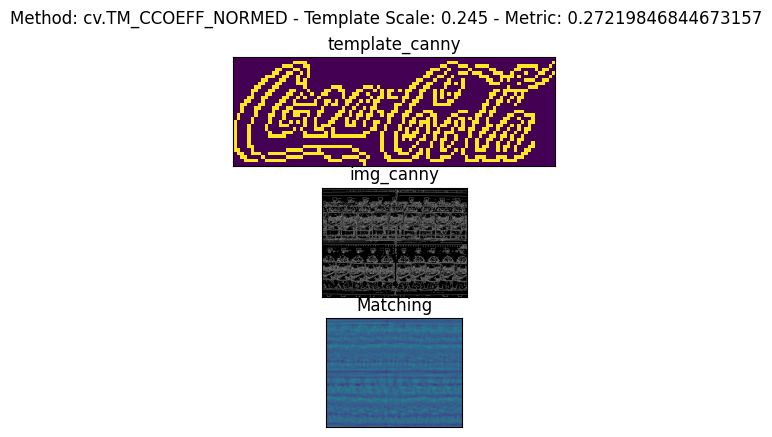

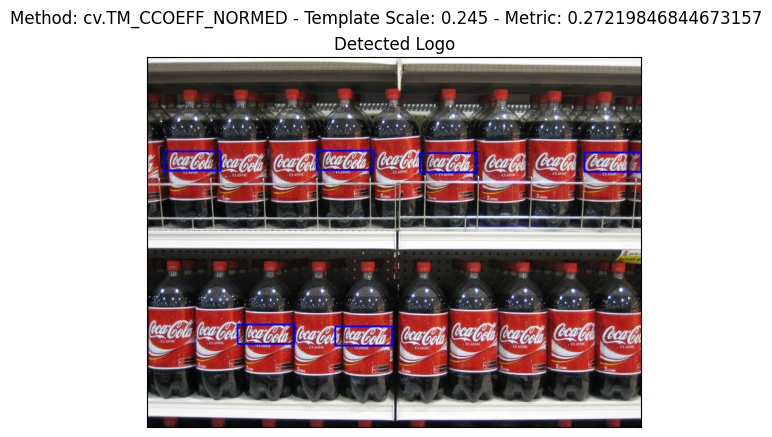

In [57]:
# Detección de logo en imagen seleccionada
imagen = 3
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.22, 0.235, 0.24, 0.245, 0.29]
canny_threshold1_img = 100
canny_threshold2_img = 100
canny_threshold1_template = 100
canny_threshold2_template = 50
threshold = 0.225 # Fijamos un umbral de "coincidencia"


best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_varios_logos(threshold,img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )


graficar_deteccion(best_template_canny, img_canny, best_res, best_scale, metodo, img_salida, best_val)


* este algoritmo debería mejorarse porque, por ejemplo, en la botella de arriba a la derecha parte del logo detectado corresponde a la botella de al lado. Si disminuyo el valor del umbral, se ven más casos del mismo estilo. Si aumento el umbral, eso no sucede pero tengo menor cantidad de logos detectados.

## ---------------------------------- PARTE 3 ----------------------------------

La solución implementada logró detectar correctamente el o los logos luego de realizar el siguiente cambio en la función de detección de varios logos:

* Como umbral de coincidencia tomé valores dentro de un rango del 0.7 al 1.3 respecto al best_val (dependiendo del método seleccionado).

Oportunidades de mejora:

* Encontrar una forma más robusta de definir el umbral de coincidencia a fin de asegurar la generilización. En el caso que elegí solo puedo garantizar que funciona con las imágenes probadas.

* Sí existe un único logo debería dibujarse un solo box, en el algoritmo que hice grafica varios porque los pixeles que cumplen con la condición del umbral son varios de los que se encuentran localizados cerca del pixel de mayor coincidencia.

In [58]:
# Definición del la función de detección de uno o varios logos seguún corresponda
def detectar_uno_a_varios_logos(img_gray, img_rgb, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template):
    
    # Carga del método para la detección
    method = eval(metodo)

    # Iteramos sobre diferentes tamaños de la plantilla (mayores y menores) y obtenemos la mejor deteccion

    ## inicializacion de varibles
    if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
        best_val = 1
    else:
        best_val = 0
    # Iteracion
    for scale in scale_list:

        # Redimensiono del template
        template_scaled = cv.resize(template_gray, None, fx=scale, fy=scale)
        
        # Si el tamaño de la plantilla es mayor que la imagen, dejamos de iterar
        if template_scaled.shape[0] > img_gray.shape[0] or template_scaled.shape[1] > img_gray.shape[1]:
            print("el tamaño de la plantilla es mayor que la imagen")
            break
        
        # Copia de la imagen color 
        img_salida = img_rgb.copy()

        # Aplico el Detector de Canny a fin de mejorar la deteccion del logo en la imagen
        img_canny = cv.Canny(img_salida, threshold1=canny_threshold1_img, threshold2=canny_threshold2_img)
        template_canny = cv.Canny(template_scaled, threshold1=canny_threshold1_template, threshold2=canny_threshold2_template)

        # Aplico el template matching con el template redimensionada
        res = cv.matchTemplate(img_canny, template_canny, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Busqueda del valore de scale que brinda la mejor detección
        if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
            if abs(min_val) < best_val:
                best_val = abs(min_val)
                top_left = min_loc
                best_res = res
                best_template_canny = template_canny
                threshold = 1.1*best_val

        else:
            if max_val > best_val:
                best_val = max_val
                top_left = max_loc
                best_res = res
                best_template_canny = template_canny
                best_scale = scale
                threshold = 0.9*best_val
 
    # Detección de logos en la imagen color

    w, h = best_template_canny.shape[::-1]
    loc = np.where( best_res >= threshold)
    for pt in zip(*loc[::-1]):
        cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

    return best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold


In [59]:
# Definición del la función de graficación de resultados, donde solo se plotea la imagen procesada
def graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold):
    plt.figure()
    plt.imshow(img_salida)
    plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
    plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val} - Threshold: {threshold} ")
    plt.show()

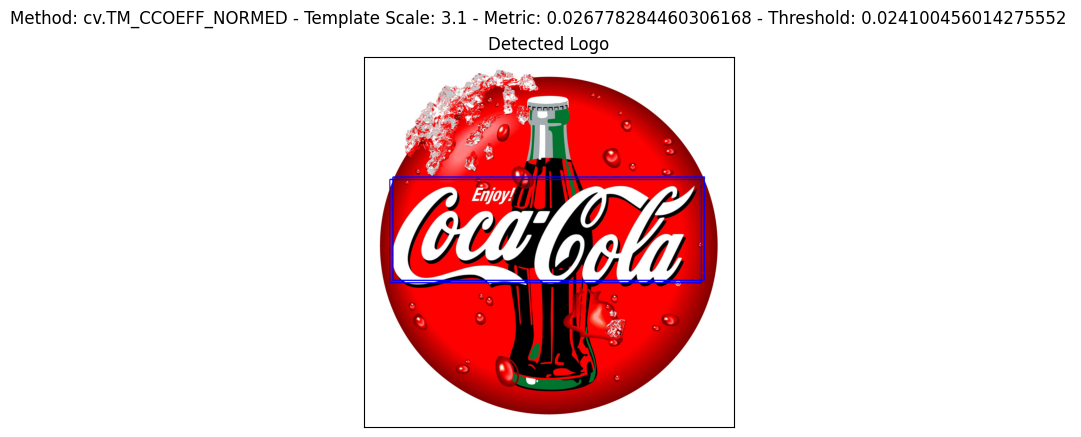

In [60]:
# Detección de logo en imagen seleccionada
imagen = 0
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 2.8, 2.9, 3, 3.1, 3.3]
canny_threshold1_img = 200
canny_threshold2_img = 200
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold = detectar_uno_a_varios_logos(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold)

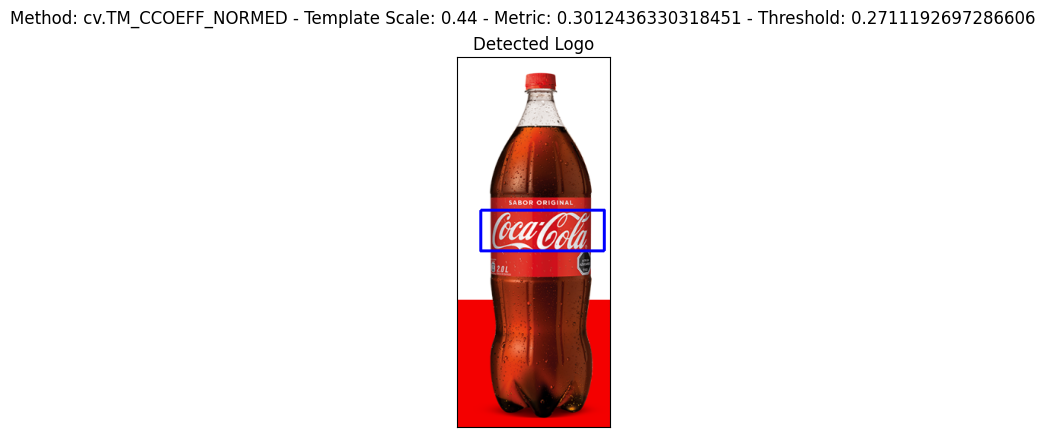

In [61]:
# Detección de logo en imagen seleccionada
imagen = 1
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [0.38, 0.40, 0.42, 0.44, 0.46, 0.48, 0.50]
canny_threshold1_img = 50
canny_threshold2_img = 100
canny_threshold1_template = 50
canny_threshold2_template = 100

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold = detectar_uno_a_varios_logos(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold)

el tamaño de la plantilla es mayor que la imagen


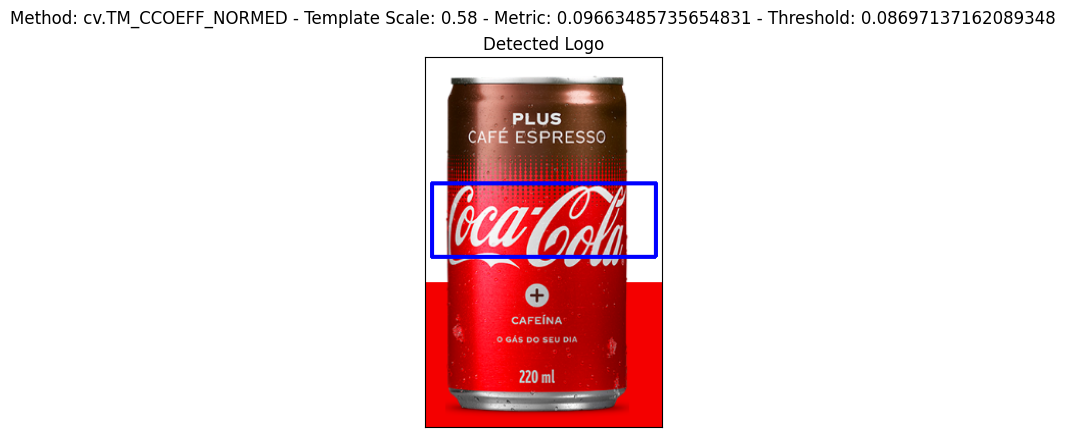

In [62]:
# Detección de logo en imagen seleccionada
imagen = 2
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [0.4, 0.58, 0.585, 0.59, 0.6, 0.65,  0.7]
canny_threshold1_img = 900
canny_threshold2_img = 925
canny_threshold1_template = 50
canny_threshold2_template = 100


best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold = detectar_uno_a_varios_logos(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold)

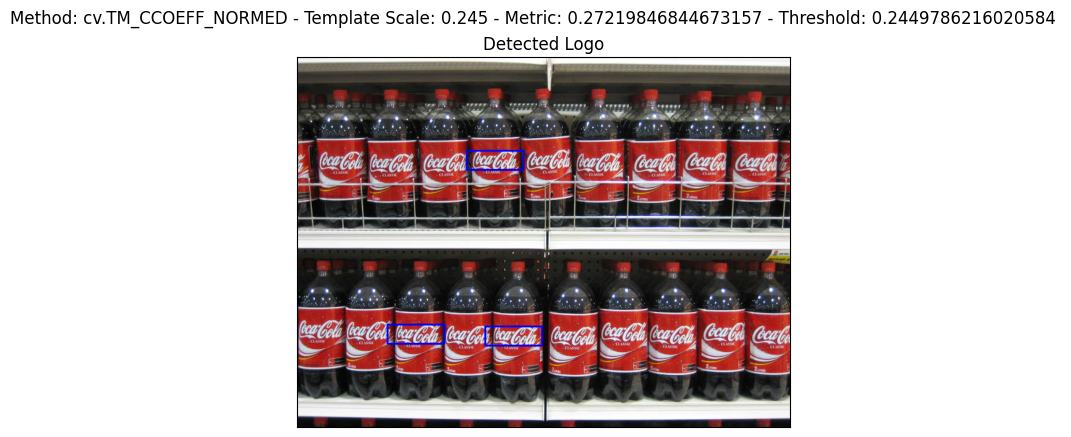

In [63]:
# Detección de logo en imagen seleccionada
imagen = 3
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.22, 0.235, 0.24, 0.245, 0.29]
canny_threshold1_img = 100
canny_threshold2_img = 100
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold = detectar_uno_a_varios_logos(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold)

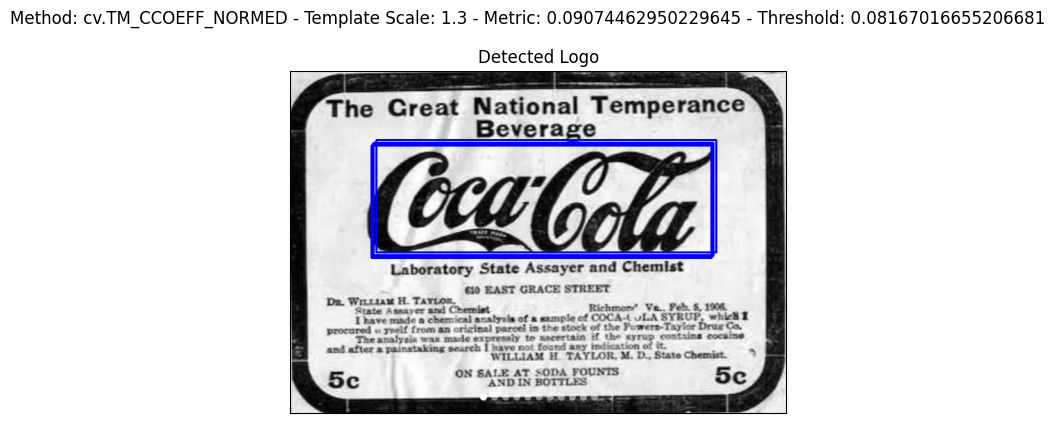

In [64]:
# Detección de logo en imagen seleccionada
imagen = 4
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.9, 1, 1.2, 1.3, 1.4]
canny_threshold1_img = 400
canny_threshold2_img = 400
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold = detectar_uno_a_varios_logos(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold)

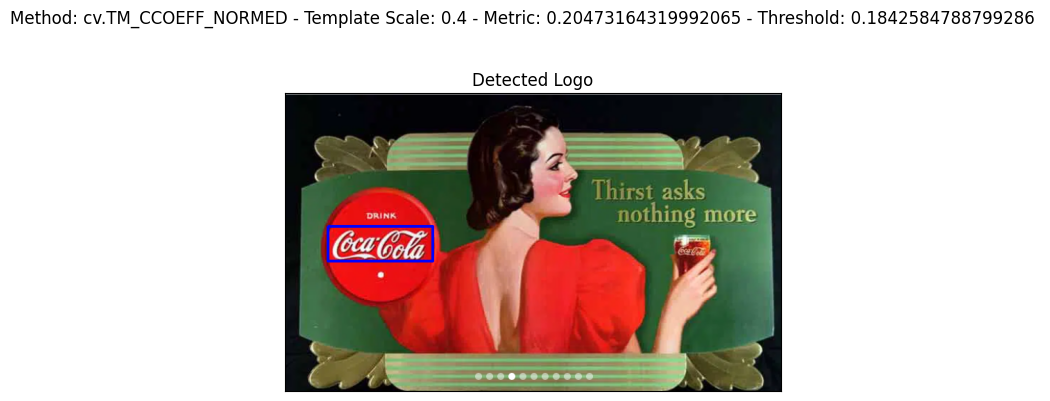

In [65]:
# Detección de logo en imagen seleccionada
imagen = 5
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.3, 0.4, 0.5, 0.6]
canny_threshold1_img = 100
canny_threshold2_img = 50
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold = detectar_uno_a_varios_logos(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold)

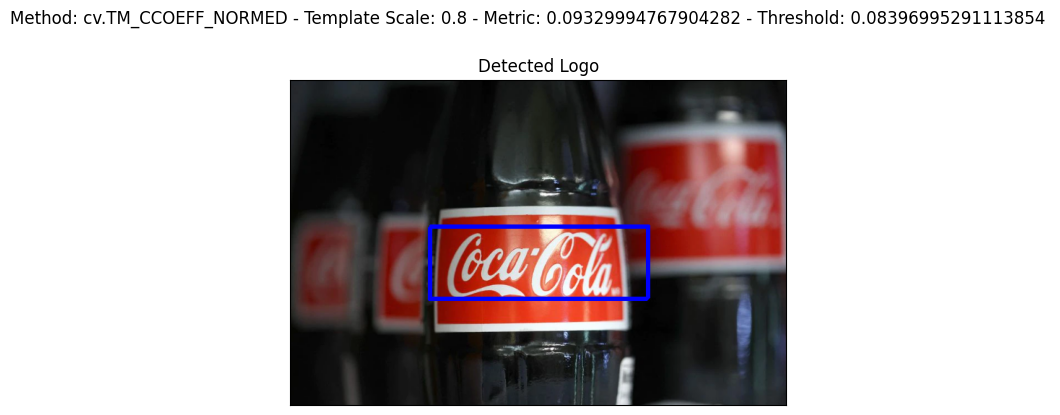

In [66]:
# Detección de logo en imagen seleccionada
imagen = 6
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.4, 0.6, 0.8, 0.9, 1, 1.25]
canny_threshold1_img = 200
canny_threshold2_img = 100
canny_threshold1_template = 200
canny_threshold2_template = 100

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale, threshold = detectar_uno_a_varios_logos(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

graficar_deteccion_uno_a_varios_logos(best_scale, metodo, img_salida, best_val, threshold)